<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/2%EA%B0%95/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

[MYCODE] Last word prediction dataset 준비      
`collate_fn` 수정

In [ ]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[MYCODE] collate_fn 변경 및 label text 확인해보기



```python
print(f"collate_fn label = {label}")
print(f"collate_fn label = {text}")
print(f"row={row}")
```



In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence
torch.set_printoptions(threshold=torch.inf)

device = 'cuda'
ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    row = row['text']

    token = tokenizer(row, truncation=True, max_length=max_len)
    label = token.input_ids[-2]
    text  = torch.LongTensor(token.input_ids[:-2])

    labels.append(label)
    texts.append(text)

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

train_loader = DataLoader(
    ds['train'], batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=128, shuffle=False, collate_fn=collate_fn
)


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


[MYCODE] 검증을 위해 하나의 데이터로 모델 학습을 확인

In [ ]:
valid_loader = DataLoader(
    ds['test'].select(range(1)), batch_size=1, shuffle=False, collate_fn=collate_fn
)

In [ ]:
batch = next(iter(train_loader))
if isinstance(batch, tuple) and len(batch) == 2:
    texts, labels = batch
    print(batch)
    print("Texts shape:", texts.shape)  # 예상: (batch_size, seq_len)
    print("Labels shape:", labels.shape)  # 예상: (batch_size,
    print("Sample labels:", labels)  # 첫 2개 라벨 샘플
    print(f"list= {texts}")

else:
    print("Unexpected batch format:", batch)


(tensor([[  101,  1045,  1005,  1040,  2074,  2066,  2000,  2360,  2008,  1045,
          1005,  2310,  2464,  2023,  2143,  3807,  2085,  1998,  1045,  2293,
          2009,   999,  1996,  3772,  2003,  2307,  1998,  2130,  2295,  2009,
          2003,  1037,  2714,  5436,  2000,  1000,  5333,  2115,  2376,  1000,
          1045,  2228,  2008,  1996,  5436,  2196,  4152, 11771,  2005,  2111,
          2040,  2066,  2008,  2785,  1997,  2518,  1012,  2009,  2038,  2070,
          2307,  8220,  1999,  2009,  1998,  3065,  2149,  2008,  2057,  2064,
          2079,  2505,  2065,  2057,  3046,  1012,  2019,  9788,  2143,  1012,
          1045,  2572,  2469,  2008,  2023,  2003,  2028,  1045,  2097,  2022,
          3666,  2005,  1037,  2146,  2051,  2000,  2272,  1012,  2130,  2295,
         29168, 13957,  4339,  1996,  2338,  2009,  2003,  3243,  1037, 12689,
          5436,  1010,  2672,  2025,  2055,  1996,  4634,  1999,  2293,  2112,
          1010,  2021,  1996,  2112,  2055,  2108, 

    # print(f"""
      #       q={q},
      #       k={k},
      #       v={v}, socre= {score}, dmodel={self.d_model}
      # """)

In [ ]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)
    return result

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.GELU(),
      nn.Linear(dff, d_model)

    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [ ]:
num_classes = len(set(ds['train']['label']))
print("Number of classes:", num_classes)

Number of classes: 2


[MYCODE] 클래스 분류 수치 조정하기

- vocab_size 로 최종 classification 값을 tokenizer로 만들기

[FEEDBACK]
- vocab_size가 tokenizer 사이즈 만큼이어야하는 이유가 무엇일까요

In [ ]:
ㄱclass TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 30522)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    return self.classification(x)


model = TextClassifier(len(tokenizer), 32, 2, 32).to(device)
print(len(tokenizer))

30522


[MYCODE] 손실함수 변경

- 이진분류에서 클래스 분류 관련 손실함수로 변경 한다.

In [ ]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

[MYCODE] 실시간 정확도 그래프 보기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def live_plot(train_accs, test_accs, title="Real-time Accuracy", label1='train', label2='test'):
    plt.clf()  # 이전 내용을 지우고 새로 그림
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1, color='blue')
    plt.plot(x, test_accs, label=label2, color='orange')
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.pause(0.1)  # 0.1초 동안 멈추고 업데이트
    plt.show(block=False)

[MYCODE] 기존 정확성대신 사이킷런 활용

In [ ]:
!pip install scikit-learn

[MYCODE] 정확도 분리

-GPU 텐서에서 numpy 사용불가로 cpu 로 이동

In [ ]:
from sklearn.metrics import accuracy_score
def accuracy(model, dataloader):
    all_preds = []
    all_labels = []

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

[MYCODE] 모델 학습 [LOG] 로그 남기기

100%|██████████| 196/196 [00:34<00:00,  5.62it/s]


Epoch   0 | Train Loss: 565.034264087677


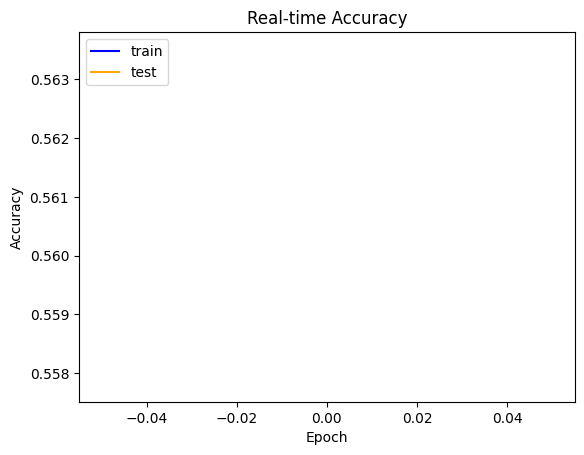

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.62it/s]


Epoch   1 | Train Loss: 554.1757423877716


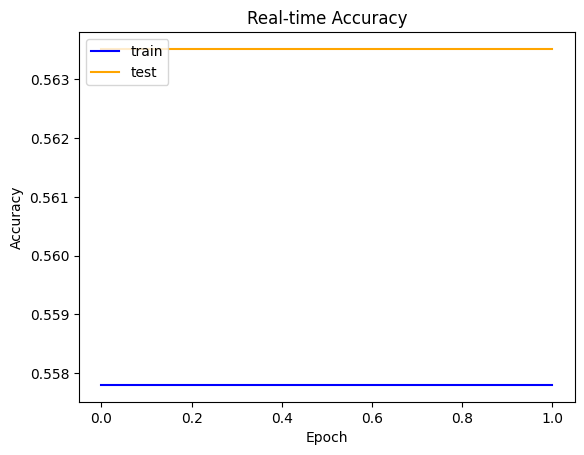

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.67it/s]


Epoch   2 | Train Loss: 543.2351883649826


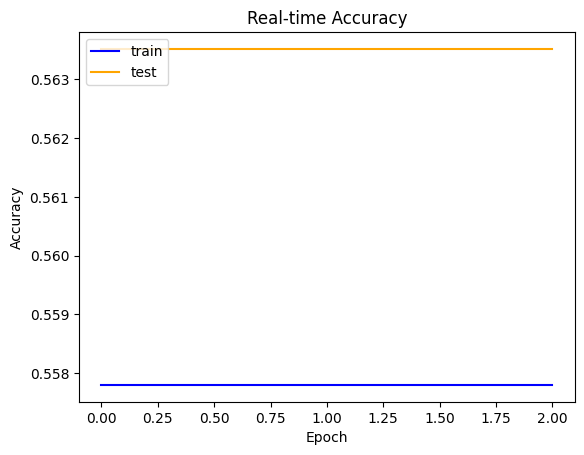

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:33<00:00,  5.78it/s]


Epoch   3 | Train Loss: 539.2436792850494


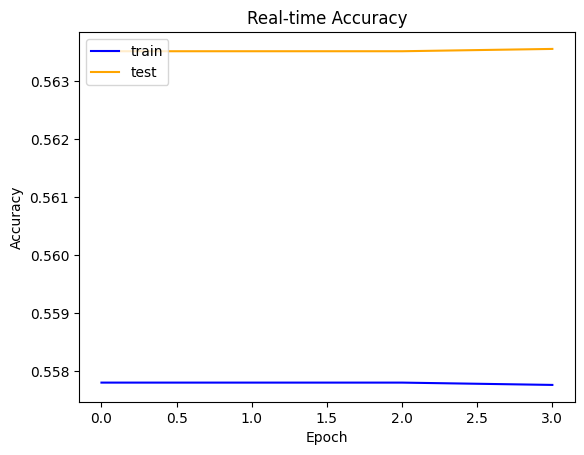

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.75it/s]


Epoch   4 | Train Loss: 535.0767257213593


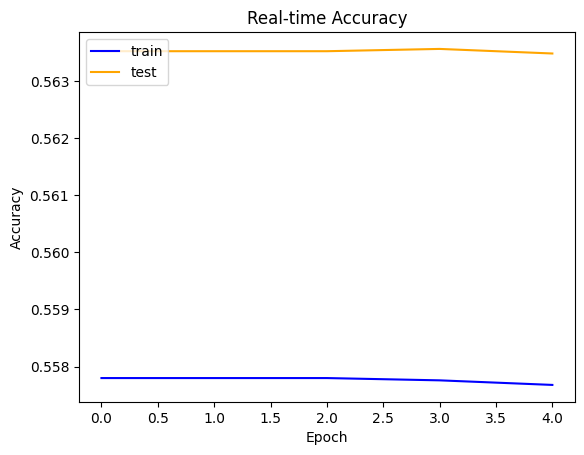

=========> Train acc: 0.558 | Test acc: 0.563


100%|██████████| 196/196 [00:34<00:00,  5.63it/s]


Epoch   5 | Train Loss: 534.010710477829


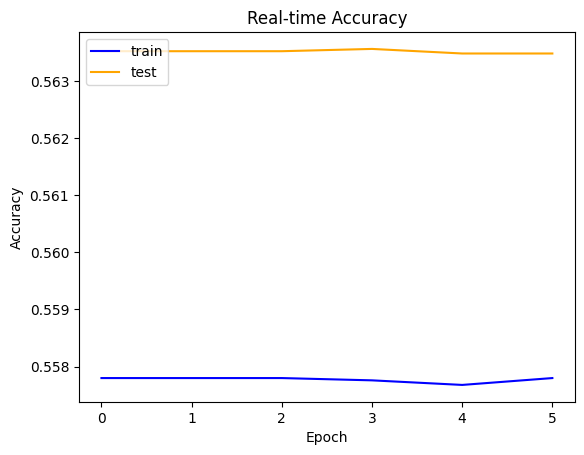

=========> Train acc: 0.558 | Test acc: 0.563


100%|██████████| 196/196 [00:34<00:00,  5.68it/s]


Epoch   6 | Train Loss: 531.0590834617615


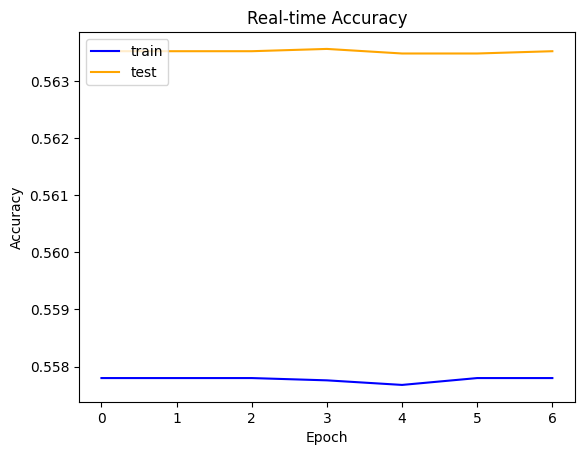

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.65it/s]


Epoch   7 | Train Loss: 529.7681223154068


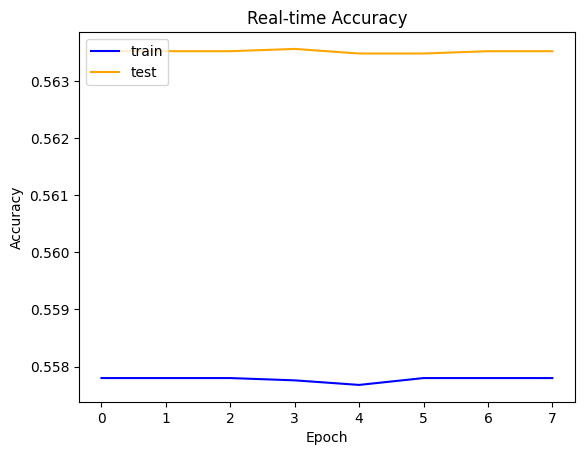

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:33<00:00,  5.84it/s]


Epoch   8 | Train Loss: 528.6641762256622


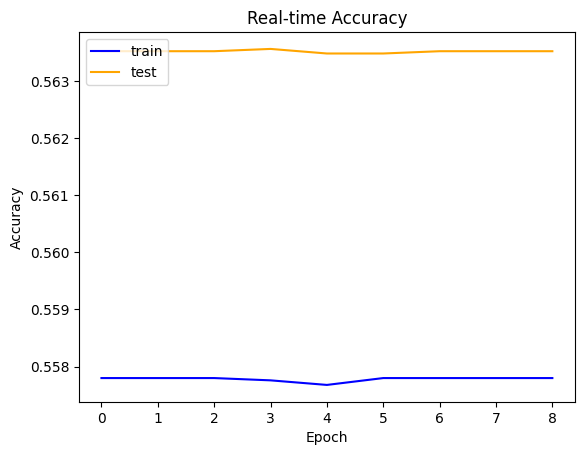

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:33<00:00,  5.79it/s]


Epoch   9 | Train Loss: 526.0187902450562


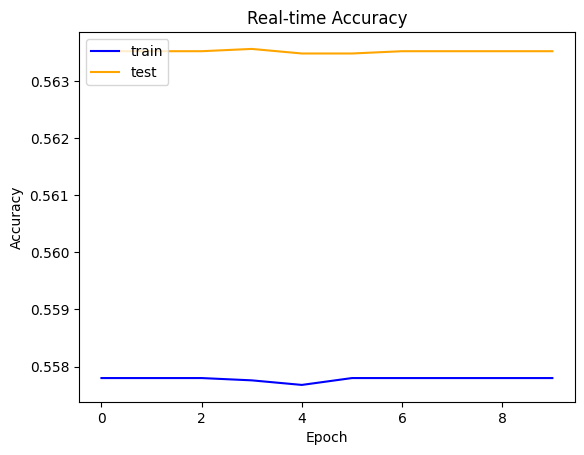

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.68it/s]


Epoch  10 | Train Loss: 525.5870184898376


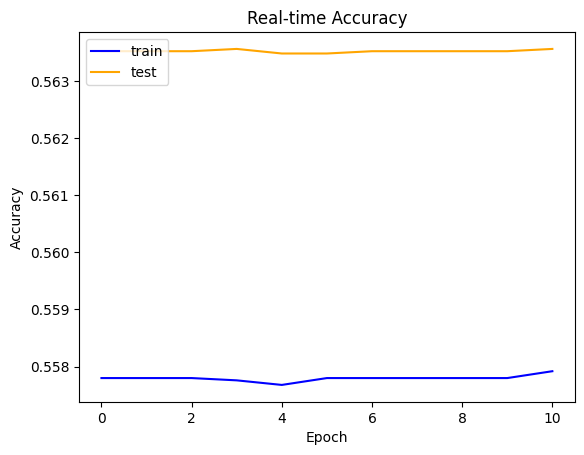

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.60it/s]


Epoch  11 | Train Loss: 525.4141694307327


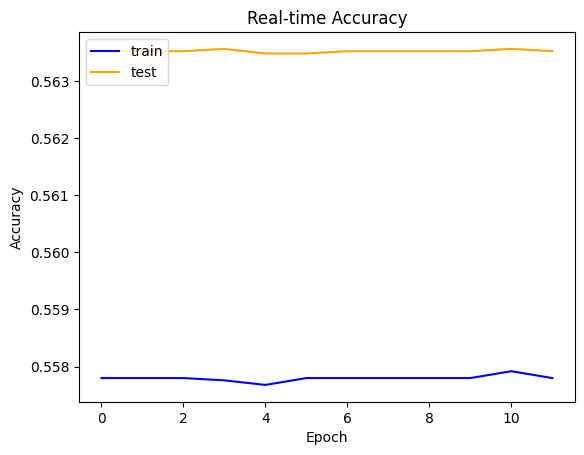

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.63it/s]


Epoch  12 | Train Loss: 525.0526869297028


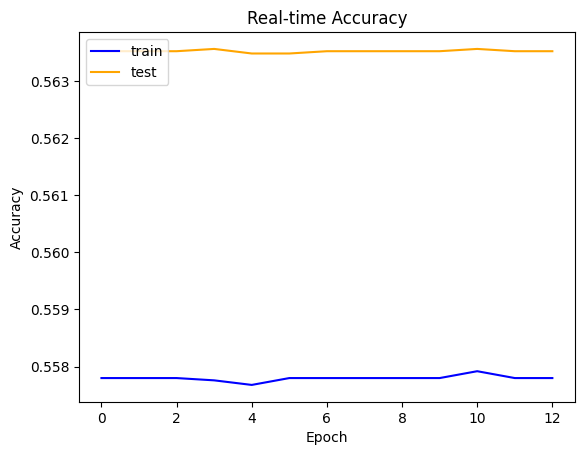

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Epoch  13 | Train Loss: 523.6641938686371


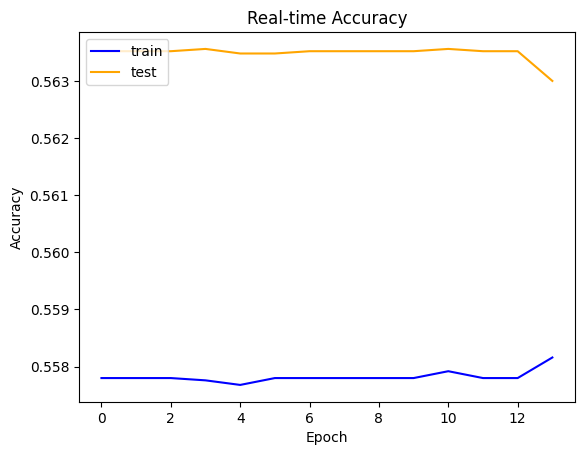

=========> Train acc: 0.558 | Test acc: 0.563


100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


Epoch  14 | Train Loss: 522.4903092384338


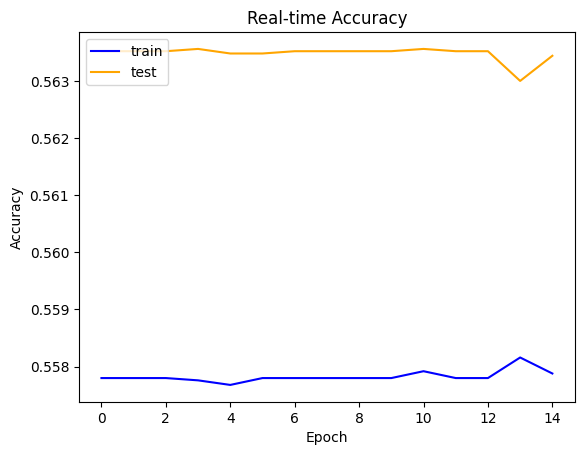

=========> Train acc: 0.558 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.44it/s]


Epoch  15 | Train Loss: 520.8956251144409


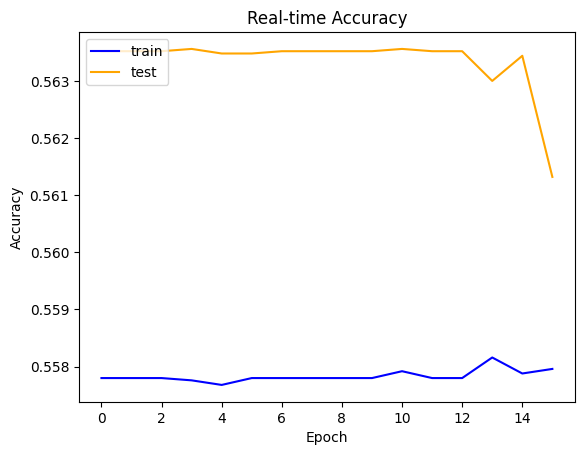

=========> Train acc: 0.558 | Test acc: 0.561


100%|██████████| 196/196 [00:36<00:00,  5.41it/s]


Epoch  16 | Train Loss: 517.3931219577789


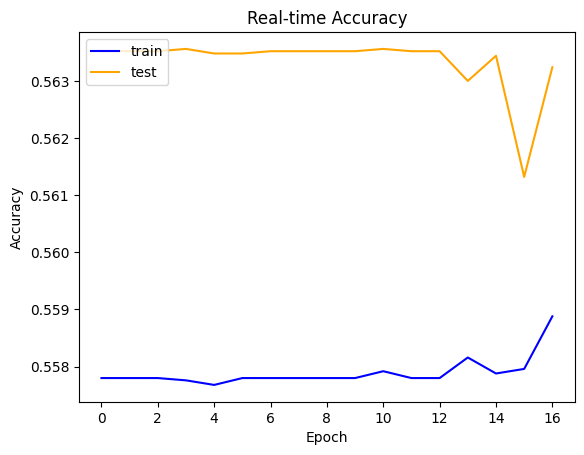

=========> Train acc: 0.559 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.31it/s]


Epoch  17 | Train Loss: 514.9340090751648


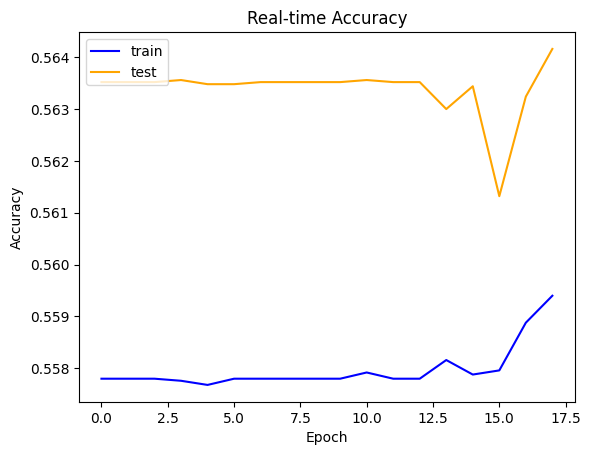

=========> Train acc: 0.559 | Test acc: 0.564


100%|██████████| 196/196 [00:35<00:00,  5.45it/s]


Epoch  18 | Train Loss: 514.1545362472534


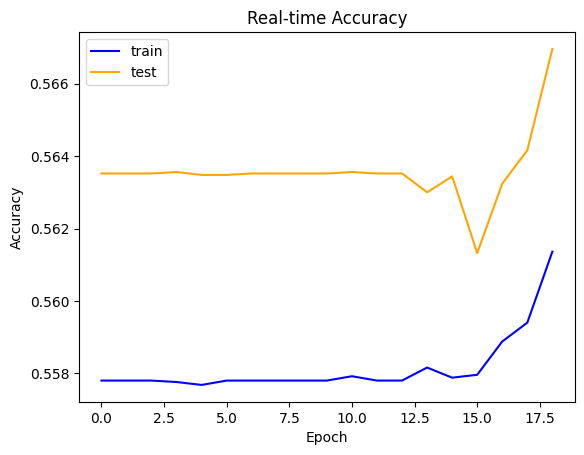

=========> Train acc: 0.561 | Test acc: 0.567


100%|██████████| 196/196 [00:35<00:00,  5.49it/s]


Epoch  19 | Train Loss: 512.3936661481857


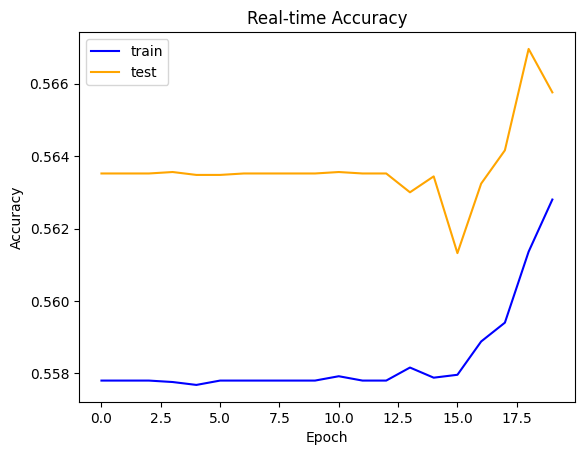

=========> Train acc: 0.563 | Test acc: 0.566


100%|██████████| 196/196 [00:36<00:00,  5.43it/s]


Epoch  20 | Train Loss: 510.98051714897156


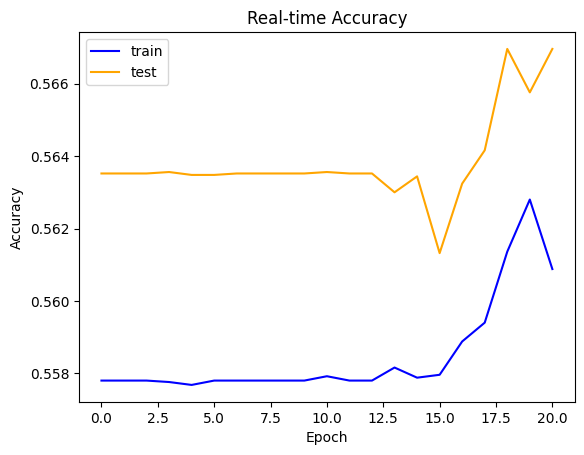

=========> Train acc: 0.561 | Test acc: 0.567


100%|██████████| 196/196 [00:36<00:00,  5.38it/s]


Epoch  21 | Train Loss: 509.68225836753845


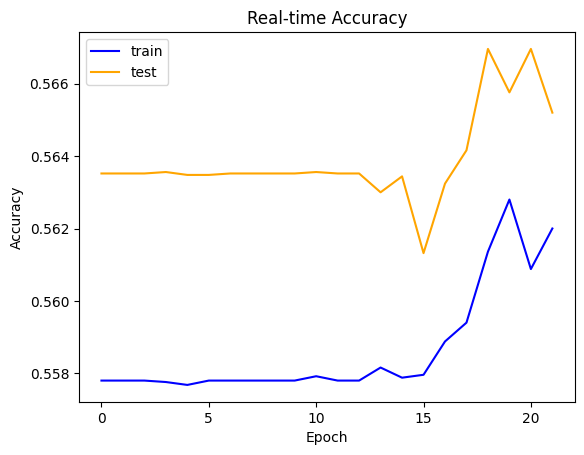

=========> Train acc: 0.562 | Test acc: 0.565


100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


Epoch  22 | Train Loss: 508.2706333398819


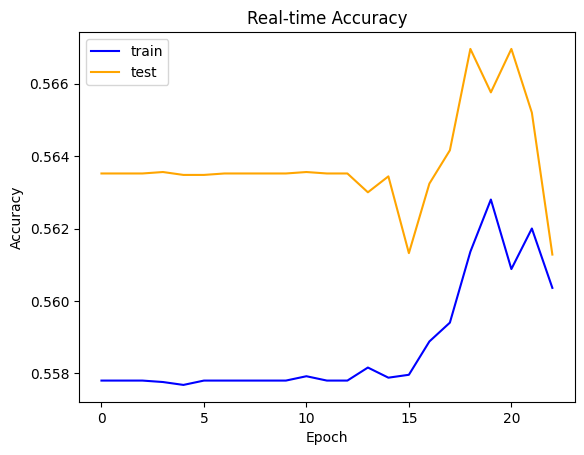

=========> Train acc: 0.560 | Test acc: 0.561


100%|██████████| 196/196 [00:36<00:00,  5.39it/s]


Epoch  23 | Train Loss: 507.6167085170746


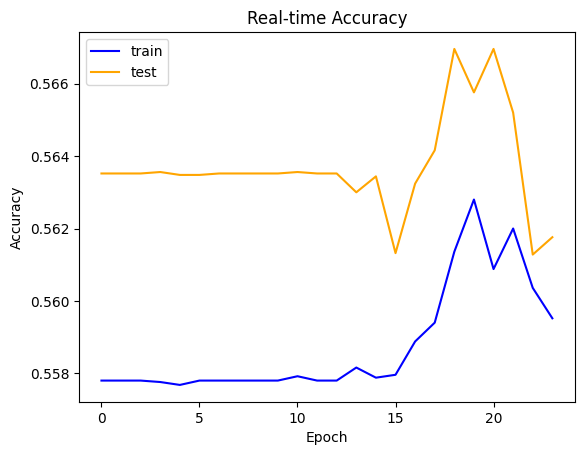

=========> Train acc: 0.560 | Test acc: 0.562


100%|██████████| 196/196 [00:36<00:00,  5.36it/s]


Epoch  24 | Train Loss: 504.98877143859863


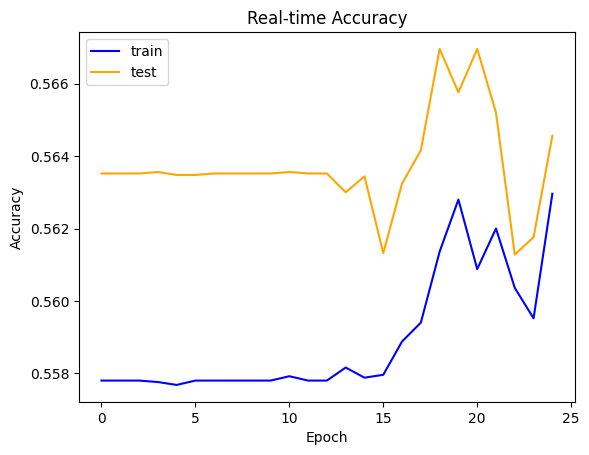

=========> Train acc: 0.563 | Test acc: 0.565


100%|██████████| 196/196 [00:36<00:00,  5.44it/s]


Epoch  25 | Train Loss: 502.8608133792877


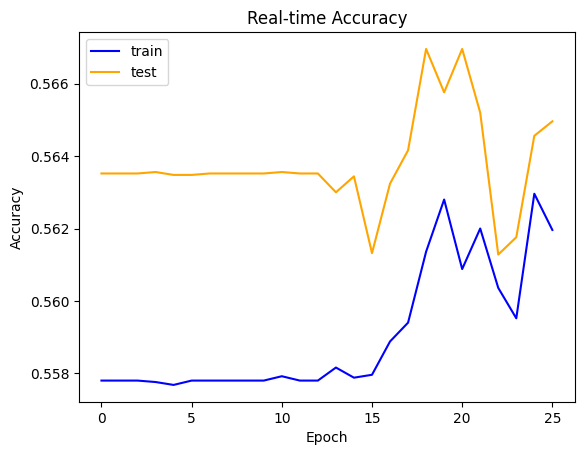

=========> Train acc: 0.562 | Test acc: 0.565


100%|██████████| 196/196 [00:35<00:00,  5.45it/s]


Epoch  26 | Train Loss: 501.36439085006714


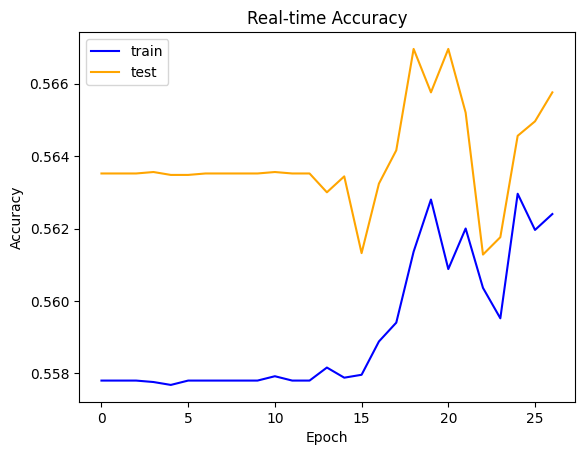

=========> Train acc: 0.562 | Test acc: 0.566


100%|██████████| 196/196 [00:36<00:00,  5.42it/s]


Epoch  27 | Train Loss: 498.89076471328735


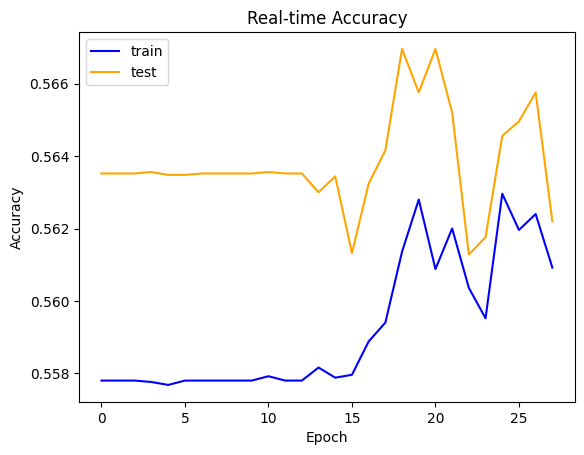

=========> Train acc: 0.561 | Test acc: 0.562


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Epoch  28 | Train Loss: 497.492729306221


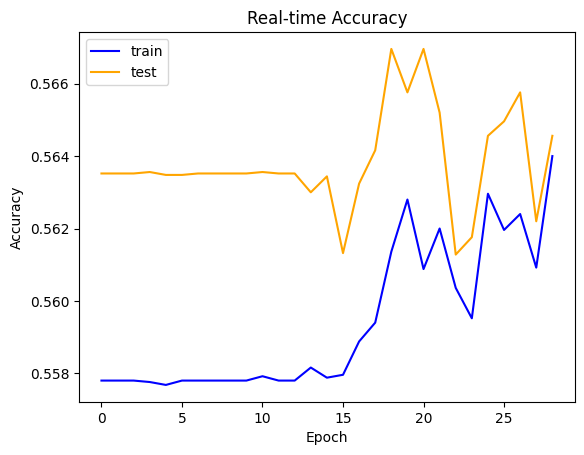

=========> Train acc: 0.564 | Test acc: 0.565


100%|██████████| 196/196 [00:36<00:00,  5.43it/s]


Epoch  29 | Train Loss: 496.2612659931183


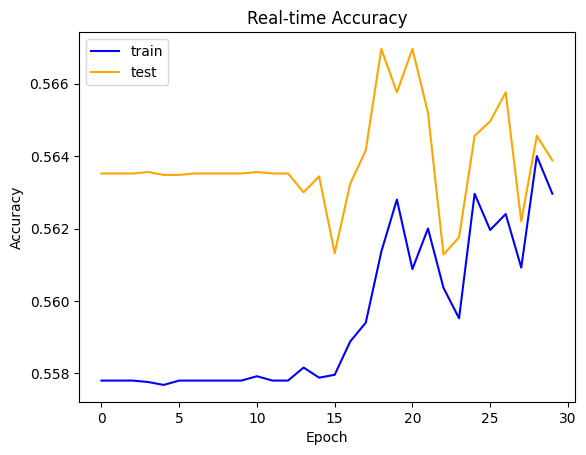

=========> Train acc: 0.563 | Test acc: 0.564


100%|██████████| 196/196 [00:36<00:00,  5.42it/s]


Epoch  30 | Train Loss: 493.96172308921814


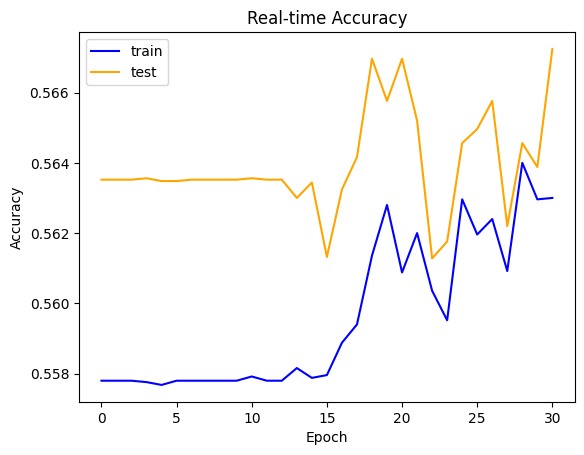

=========> Train acc: 0.563 | Test acc: 0.567


100%|██████████| 196/196 [00:35<00:00,  5.52it/s]


Epoch  31 | Train Loss: 492.45849430561066


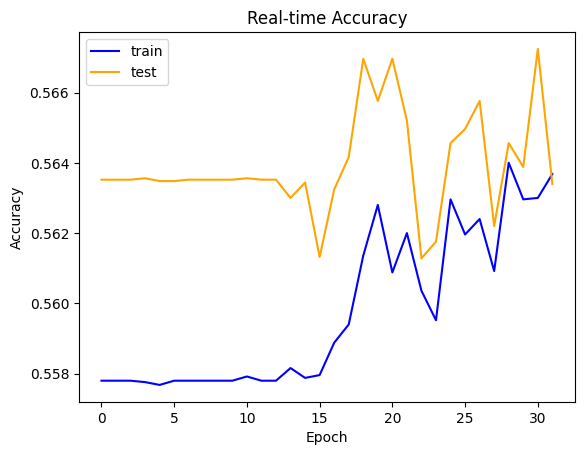

=========> Train acc: 0.564 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.38it/s]


Epoch  32 | Train Loss: 490.05032873153687


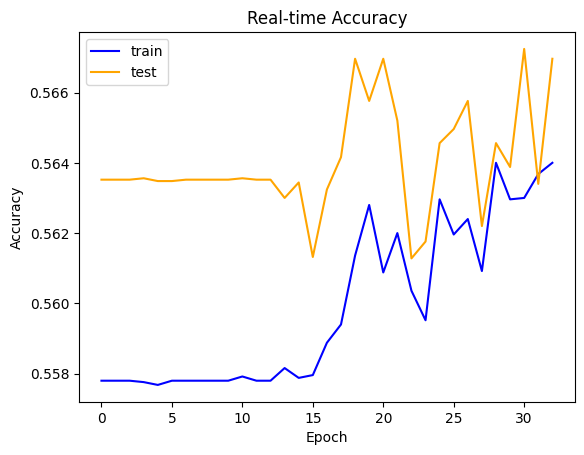

=========> Train acc: 0.564 | Test acc: 0.567


100%|██████████| 196/196 [00:36<00:00,  5.44it/s]


Epoch  33 | Train Loss: 489.27631294727325


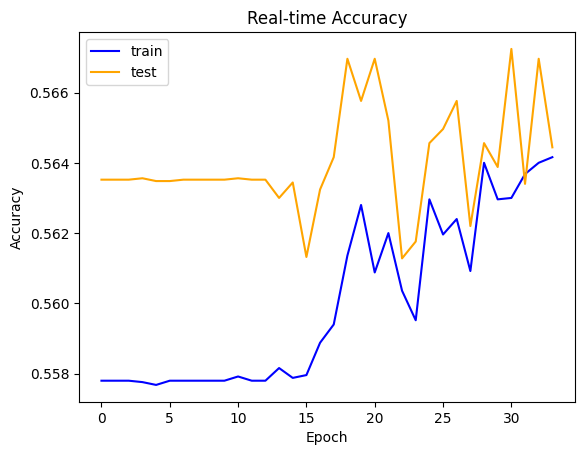

=========> Train acc: 0.564 | Test acc: 0.564


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Epoch  34 | Train Loss: 487.3693883419037


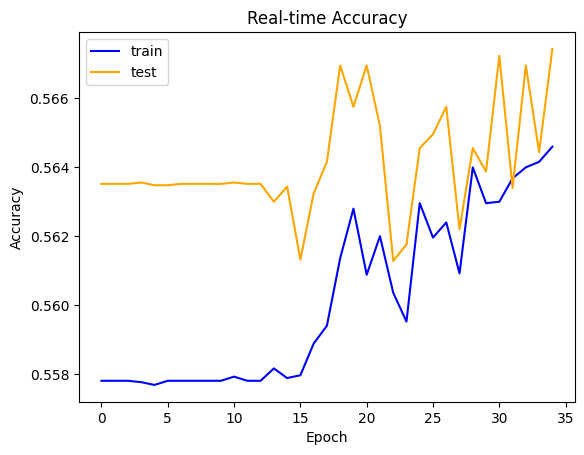

=========> Train acc: 0.565 | Test acc: 0.567


100%|██████████| 196/196 [00:39<00:00,  4.97it/s]


Epoch  35 | Train Loss: 485.45659244060516


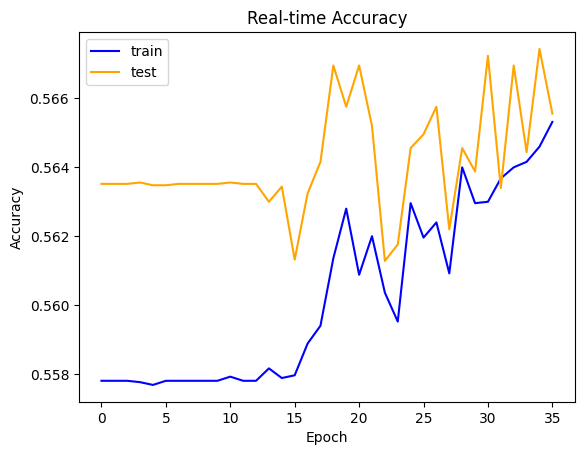

=========> Train acc: 0.565 | Test acc: 0.566


100%|██████████| 196/196 [00:36<00:00,  5.39it/s]


Epoch  36 | Train Loss: 483.1453585624695


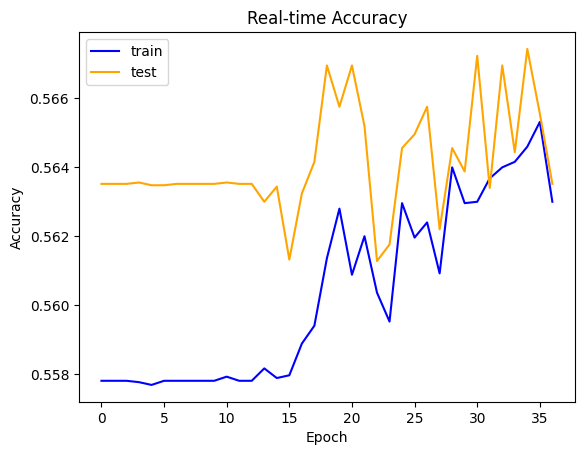

=========> Train acc: 0.563 | Test acc: 0.564


100%|██████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch  37 | Train Loss: 482.38487207889557


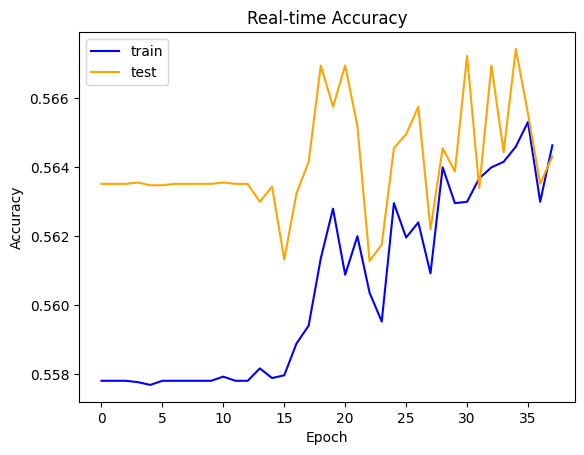

=========> Train acc: 0.565 | Test acc: 0.564


100%|██████████| 196/196 [00:36<00:00,  5.35it/s]


Epoch  38 | Train Loss: 479.9514307975769


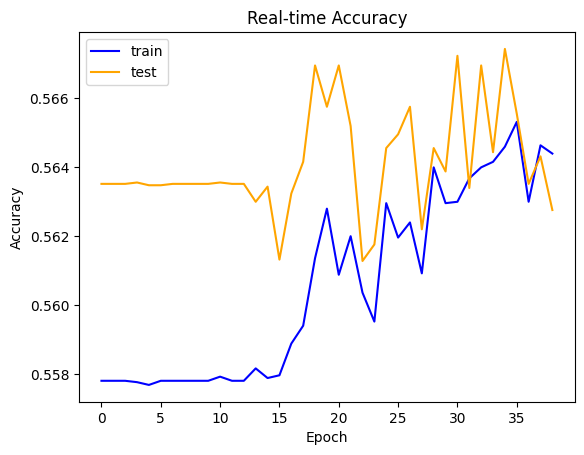

=========> Train acc: 0.564 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.42it/s]


Epoch  39 | Train Loss: 478.0968656539917


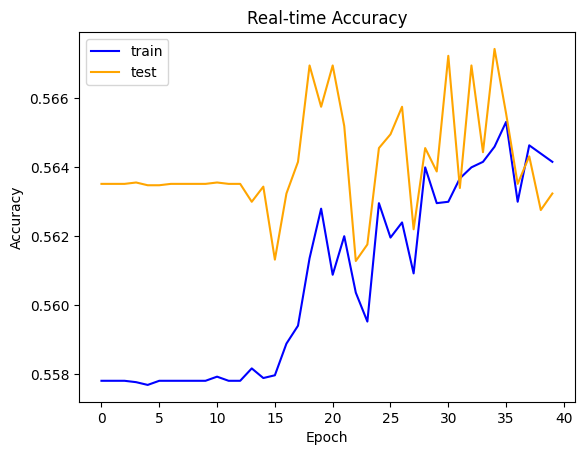

=========> Train acc: 0.564 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.38it/s]


Epoch  40 | Train Loss: 477.63885855674744


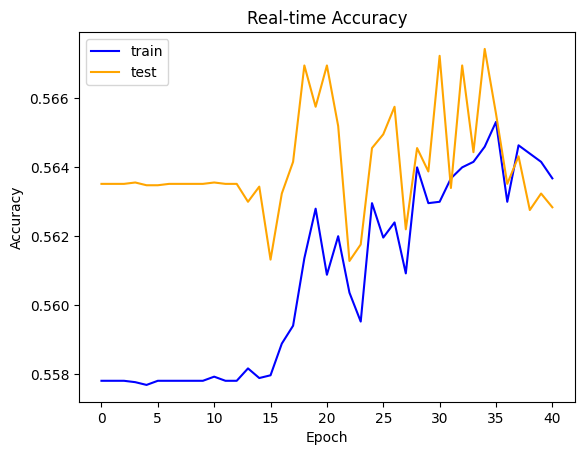

=========> Train acc: 0.564 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.32it/s]


Epoch  41 | Train Loss: 476.516606092453


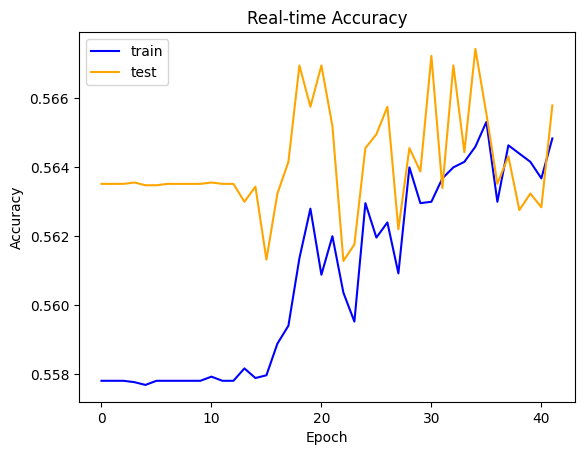

=========> Train acc: 0.565 | Test acc: 0.566


100%|██████████| 196/196 [00:36<00:00,  5.35it/s]


Epoch  42 | Train Loss: 474.4556441307068


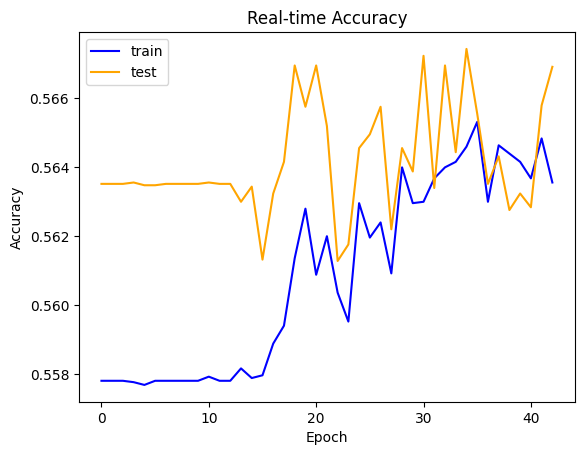

=========> Train acc: 0.564 | Test acc: 0.567


100%|██████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch  43 | Train Loss: 471.8750067949295


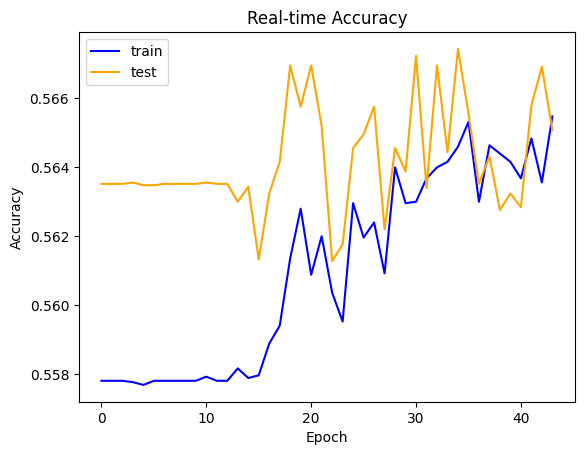

=========> Train acc: 0.565 | Test acc: 0.565


100%|██████████| 196/196 [00:36<00:00,  5.31it/s]


Epoch  44 | Train Loss: 470.13478207588196


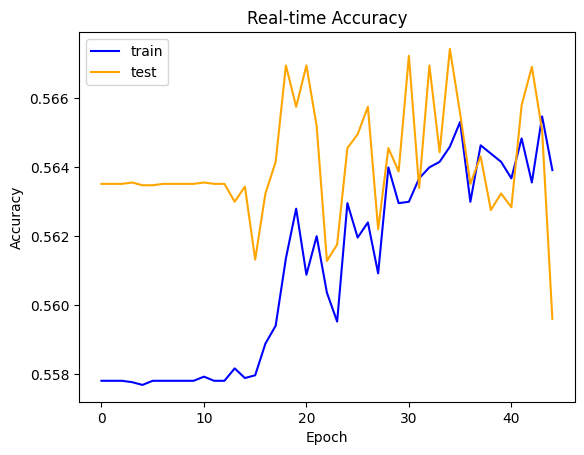

=========> Train acc: 0.564 | Test acc: 0.560


100%|██████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch  45 | Train Loss: 467.78667306900024


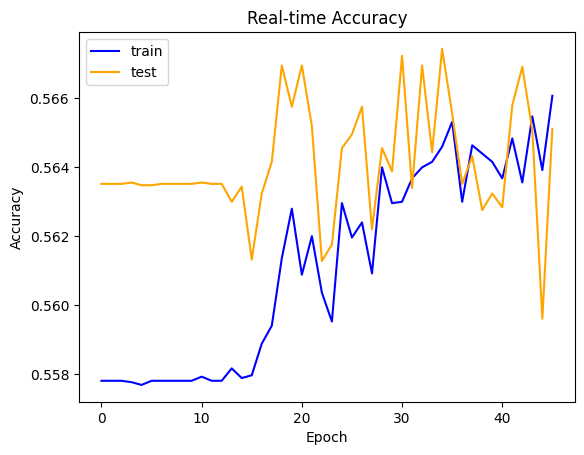

=========> Train acc: 0.566 | Test acc: 0.565


100%|██████████| 196/196 [00:36<00:00,  5.37it/s]


Epoch  46 | Train Loss: 467.27460503578186


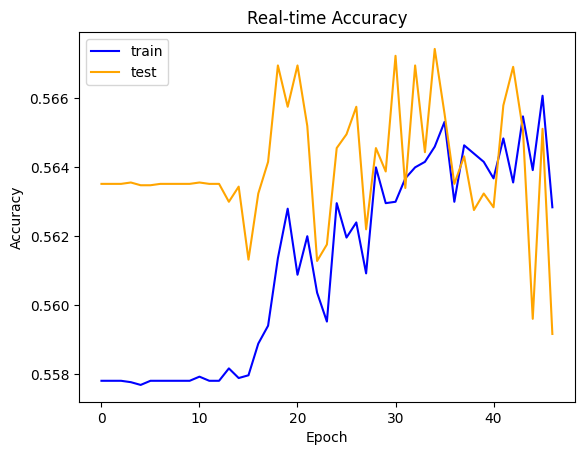

=========> Train acc: 0.563 | Test acc: 0.559


100%|██████████| 196/196 [00:36<00:00,  5.36it/s]


Epoch  47 | Train Loss: 465.32471668720245


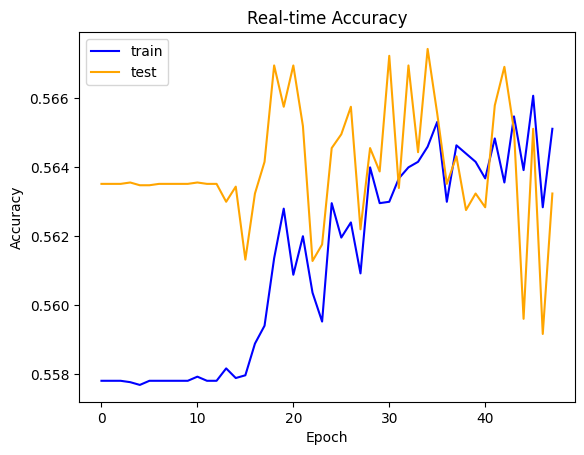

=========> Train acc: 0.565 | Test acc: 0.563


100%|██████████| 196/196 [00:36<00:00,  5.34it/s]


Epoch  48 | Train Loss: 463.33172726631165


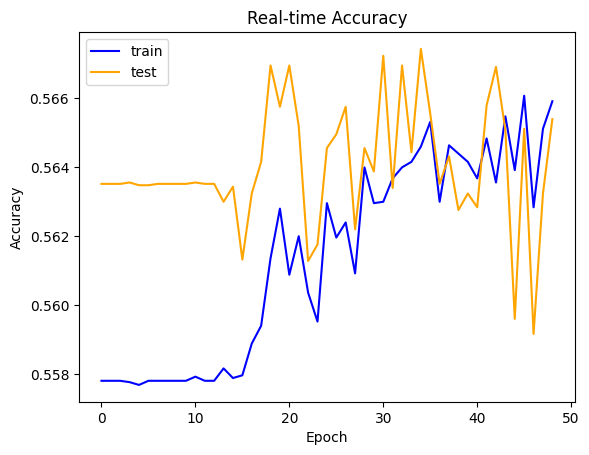

=========> Train acc: 0.566 | Test acc: 0.565


100%|██████████| 196/196 [00:36<00:00,  5.33it/s]


Epoch  49 | Train Loss: 460.9760648012161


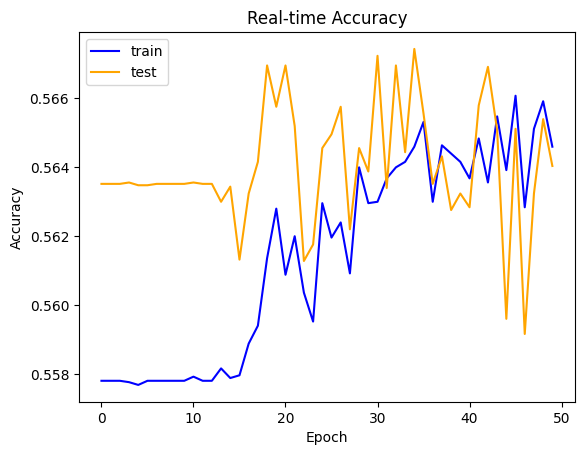

=========> Train acc: 0.565 | Test acc: 0.564


In [ ]:
from tqdm import tqdm
n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in (tqdm(train_loader)):
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    live_plot(train_accs,test_accs)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

[LOG] 50 epochs 결과

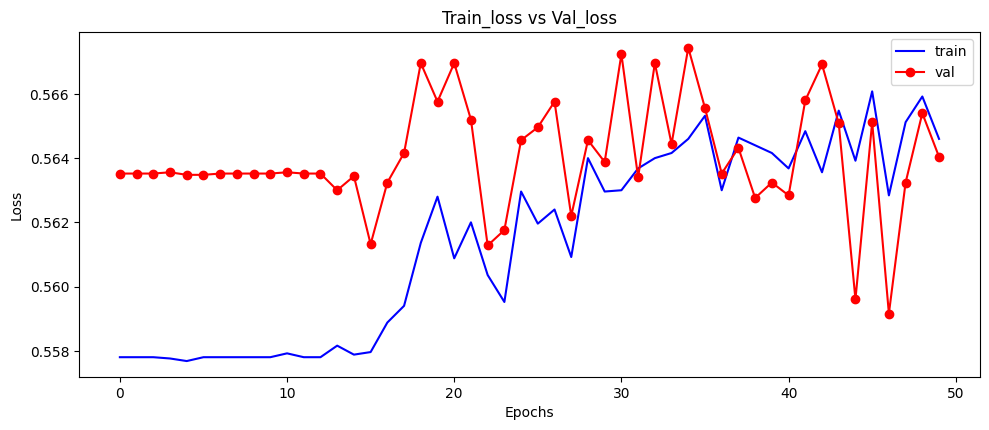

In [ ]:

# 플롯 크기 설정
plt.figure(figsize=(10, 8))

# 1번째 서브플롯: Train_loss vs test
plt.subplot(2, 1, 1)
x = np.arange(len(train_accs))
plt.plot(x, train_accs, label='train', color='blue')  # 훈련 손실
plt.plot(x, test_accs, label='val', color='red', marker='o')  # 검증 손실
plt.title("Train_loss vs Val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


# 플롯 간격 조정 및 출력
plt.tight_layout()
plt.show()

[MYCODE] 모델 가중치 저장


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')